### 1.包导入

In [1]:
import gym
import torch as T
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt

### 2.环境尝试

In [2]:
env = gym.make("CartPole-v1")
env.reset()
env.step(0)

(array([ 0.01123191, -0.23852387,  0.007113  ,  0.32618317], dtype=float32),
 1.0,
 False,
 False,
 {})

### 3.定义 Actor 网络

In [3]:
# 定义策略网络
class ActorNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.device = T.device("cuda" if T.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, x):
        x = T.tensor(x, dtype=T.float32).to(self.device)
        layer1 = T.relu(self.fc1(x))
        layer2 = T.relu(self.fc2(layer1))
        p = T.softmax(self.fc3(layer2), dim=-1)
        return p

### 4. 定义 Critic 网络

In [4]:
class Critic(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        self.device = T.device("cuda" if T.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, x):
        x = T.tensor(x, dtype=T.float32).to(self.device)
        layer1 = T.relu(self.fc1(x))
        layer2 = T.relu(self.fc2(layer1))
        value = self.fc3(layer2)
        return value


### 5.设置环境和超参数

In [5]:
# 设置环境
env = gym.make("CartPole-v1")
input_dim = env.observation_space.shape[0]  # 输入维度
hidden_dim = 128
output_dim = env.action_space.n  # 输出维度
# 设置超参数
batch_size = 20  # 设置每次更新的轨迹数量
gamma = 0.9  # 奖励折扣因子
avg_episode = 50
save_episode = 200
print_episode = 50
clip_norm = 100
continue_train = True
num_episodes = 0
learning_rate = 1e-4

# 学习进度保存路径
actor_model_path = "./save/s7_actor_net.pth"
critic_model_path = "./save/s7_critic_net.pth"
avg_path = "./save/s7_avg_rewards.pth"

In [6]:
actor_net = ActorNetwork(input_dim, hidden_dim, output_dim)
critic_net = Critic(input_dim, hidden_dim)
actor_optimizer = optim.AdamW(actor_net.parameters(), lr=learning_rate)
critic_optimizer = optim.AdamW(critic_net.parameters(), lr=learning_rate)
avg_rewards = []

if continue_train:
    if os.path.exists(actor_model_path) and os.path.exists(critic_model_path) and os.path.exists(avg_path):
        actor_net.load_state_dict(T.load(actor_model_path))
        actor_net.to(actor_net.device)
        critic_net.load_state_dict(T.load(critic_model_path))
        critic_net.to(critic_net.device)
        with open(avg_path, "rb") as f:
            avg_rewards = pickle.load(f)
len(avg_rewards)

/tmp/ipykernel_50215/800411927.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  actor_net.load_state_dict(T.load(actor_model_path))
/tmp/ipykernel_50215/800411927.py:11: 

40

### 6.开始训练

In [7]:
# 开始训练
record_rewards = []
for episode in range(1, num_episodes + 1):
    total_reward = []
    episode_reward = 0
    state = env.reset()[0]

    for _ in range(1000):# 设置最大步长
        probs = actor_net(state)
        m = Categorical(probs)
        action = m.sample()
        next_state, reward, terminated, truncated, info = env.step(action.item())

        done = bool(terminated) or bool(truncated)

        episode_reward += reward

        # Critic 估计当前状态值
        value = critic_net(state)
        next_state_value = critic_net(next_state)

        # 计算 TD 误差和优势，如果终止，则忽略下一状态
        td_target = reward + gamma * next_state_value * (1 - int(done))
        td_error = td_target - value

        # Critic 网络更新
        critic_loss = td_error.pow(2)
        critic_optimizer.zero_grad()
        critic_loss.backward()  
        critic_optimizer.step()

        # Actor 网络更新
        actor_loss = -m.log_prob(action) * td_error.detach() # 用detach()切断梯度,避免actor网络更新影响Critic网络更新    
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()

        if done:
            break
        else:
            state = next_state

    record_rewards.append(episode_reward)

    # 输出训练进度
    if episode % avg_episode == 0:
        avg_reward = sum(record_rewards[-avg_episode:]) / avg_episode
        avg_rewards.append(avg_reward)
        if episode % print_episode == 0:
            print(
                f"Episode {episode}, Current Reward:{record_rewards[-1]}, Avg Reward: {avg_reward}"
            )
        if episode % save_episode == 0:
            print(f"to save model and avg_rewards {len(avg_rewards)}")
            T.save(actor_net.state_dict(), actor_model_path)
            T.save(critic_net.state_dict(), critic_model_path)
            with open(avg_path, "wb") as f:
                pickle.dump(avg_rewards, f)

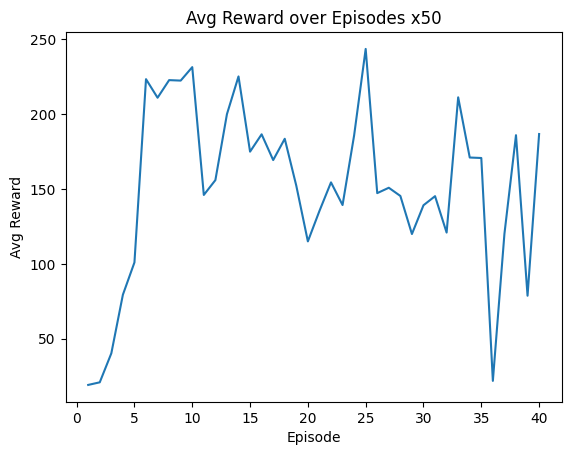

In [8]:
# 绘制得分变化图
plt.plot(range(1, len(avg_rewards) + 1), avg_rewards)
plt.xlabel("Episode")
plt.ylabel("Avg Reward")
plt.title(f"Avg Reward over Episodes x{avg_episode}")
plt.show()